This notebook is an example for fitting multiple peaks into a spectrum

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from lmfit import Model
from numpy import exp, loadtxt, pi, sqrt
from lmfit import models

In [28]:
data = pd.read_csv('./sample_spectrum.csv')

In [29]:
data.head()

,Energies (eV),Cu1.5Te-629332-full/Cu1.0
0,8970.00,0.03
1,8970.81,0.03
2,8971.62,0.03
3,8972.42,0.04
4,8973.23,0.04


In [30]:
energy = data.iloc[:,0]
intensity = data.iloc[:,1]

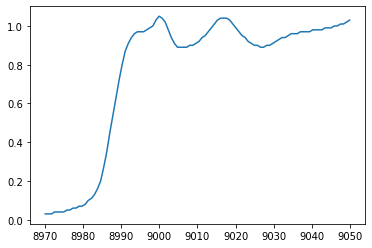

In [31]:
plt.plot(energy,intensity)

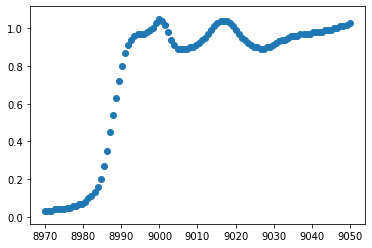

In [32]:
plt.scatter(energy,intensity)

In [33]:
x = energy
y = intensity

In [34]:
gmodel = Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_') +  Model(gaussian, prefix='p3_')

result  = gmodel.fit(y, x=x, p1_amp=50, p1_cen=284.8, p1_wid=0.005,
                     p2_amp=5, p2_cen=286, p2_wid=0.005, p3_amp=10, p3_cen=288.5, p3_wid=0.005 )

print(result.fit_report())

plt.plot(x, y, 'bo')
#plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()
# <end examples/doc_model_gaussian.py>

NameError: name 'gaussian' is not defined

In [0]:
gmodel = Model(gaussian, prefix='p1_') + Model(gaussian, prefix='p2_') +  Model(gaussian, prefix='p3_')

params = gmodel.make_params(p1_amp=0.1, p1_cen=285, p1_wid=0.005,
                            p2_amp=0.5, p2_cen=286, p2_wid=0.005, p3_amp=10, p3_cen=288.5, p3_wid=0.005 )
params['p1_cen'].min = 284
params['p1_cen'].max = 286
params['p2_cen'].min = 285.5
params['p2_cen'].max = 287.5
params['p3_cen'].min = 288
params['p3_cen'].max = 290


result = gmodel.fit(y, params, x=x)

In [36]:
from lmfit import models

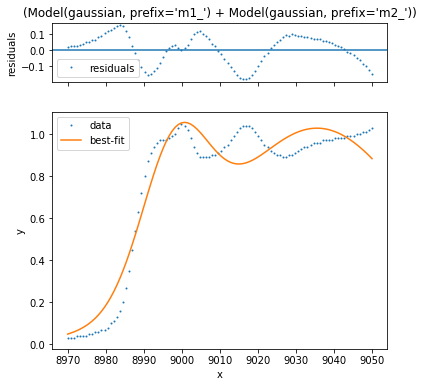

In [38]:
model_1 = models.GaussianModel(prefix='m1_')
model_2 = models.GaussianModel(prefix='m2_')
#model_3 = models.GaussianModel(prefix='m3_')
model = model_1 + model_2

params_1 = model_1.make_params(center=8995, sigma=1)
params_2 = model_2.make_params(center=9015, sigma=1)

params = params_1.update(params_2)

output = model.fit(y, params, x=x)
fig, gridspec = output.plot(data_kws={'markersize': 1})

In [39]:
import random

In [40]:
def generate_model(spec):
    composite_model = None
    params = None
    x = spec['x']
    y = spec['y']
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    y_max = np.max(y)
    for i, basis_func in enumerate(spec['model']):
        prefix = f'm{i}_'
        model = getattr(models, basis_func['type'])(prefix=prefix)
        if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']: # for now VoigtModel has gamma constrained to sigma
            model.set_param_hint('sigma', min=1e-6, max=x_range)
            model.set_param_hint('center', min=x_min, max=x_max)
            model.set_param_hint('height', min=1e-6, max=1.1*y_max)
            model.set_param_hint('amplitude', min=1e-6)
            # default guess is horrible!! do not use guess()
            default_params = {
                prefix+'center': x_min + x_range * random.random(),
                prefix+'height': y_max * random.random(),
                prefix+'sigma': x_range * random.random()
            }
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
        if 'help' in basis_func:  # allow override of settings in parameter
            for param, options in basis_func['help'].items():
                model.set_param_hint(param, **options)
        model_params = model.make_params(**default_params, **basis_func.get('params', {}))
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if composite_model is None:
            composite_model = model
        else:
            composite_model = composite_model + model
    return composite_model, params

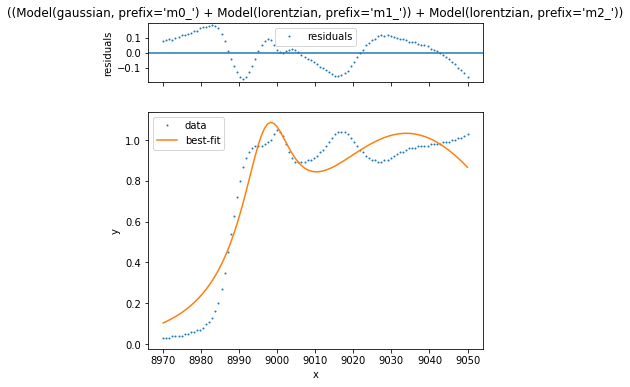

In [41]:
spec = {
    'x': x,
    'y': y,
    'model': [
        {'type': 'GaussianModel'},
        {'type': 'LorentzianModel'},
        {'type': 'LorentzianModel'}
    ]
}

model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize': 1})

In [42]:
def update_spec_from_peaks(spec, model_indicies, peak_widths=(10, 25), **kwargs):
    x = spec['x']
    y = spec['y']
    x_range = np.max(x) - np.min(x)
    peak_indicies = signal.find_peaks_cwt(y, peak_widths)
    np.random.shuffle(peak_indicies)
    for peak_indicie, model_indicie in zip(peak_indicies.tolist(), model_indicies):
        model = spec['model'][model_indicie]
        if model['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']:
            params = {
                'height': y[peak_indicie],
                'sigma': x_range / len(x) * np.min(peak_widths),
                'center': x[peak_indicie]
            }
            if 'params' in model:
                model.update(params)
            else:
                model['params'] = params
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
    return peak_indicies

In [43]:
spec = {
    'x': x,
    'y': y,
    'model': [
        {'type': 'GaussianModel','params': {'center': 285, 'height': 5000, 'sigma': 0.1},
            'help': {'center': {'min': 283, 'max': 287}}},
        {'type': 'GaussianModel',},
        {'type': 'GaussianModel'},
    ]
}



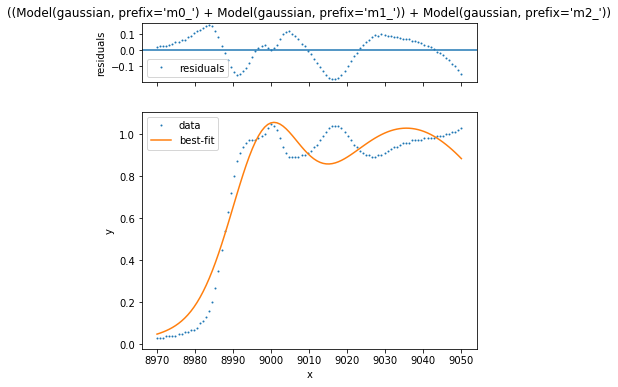

In [44]:
model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize':  1})

3


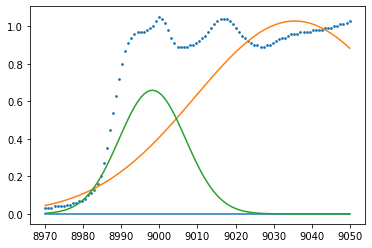

In [45]:
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=3)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])

In [46]:
spec = {
    'x': x,
    'y': y,
    'model': [
        {
            'type': 'GaussianModel',
            'params': {'center': 285, 'height': 5000, 'sigma': 0.1},
            'help': {'center': {'min': 283, 'max': 287}}
        },
        {
            'type': 'GaussianModel',
            'params': {'center': 286, 'height': 1000, 'sigma': 0.1, 'gamma': 0.1},
            'help': {'center': {'min': 285, 'max': 288}}
        },
        {
            'type': 'GaussianModel',
            'params': {'center': 288.3, 'height': 1000, 'sigma': 0.1},
            'help': {'center': {'min': 287, 'max': 290}}}
    ]
}
            



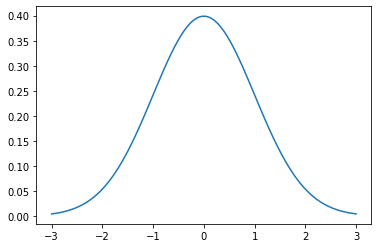

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()